# __5.5 Практическая работа__

### Цель практической работы

Закрепить знания, полученные при просмотре видео, решив задачу классификации цветных изображений. Вы поработаете с новым набором данных и построите оптимальный классификатор, используя callbacks и поиск оптимальных гиперпараметров.

## __Шаги__

### 1. Импортируйте все необходимые библиотеки.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# pip install keras-tuner --upgrade

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import keras
from keras.layers import *
from keras.utils import to_categorical, plot_model
from keras.regularizers import l2
import keras_tuner

### 2. Загрузите из keras.datasets набор данных cifar10.

In [5]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

### 3. Ознакомьтесь с данными, используя различные методы. Сделайте выводы об этом наборе данных.

In [5]:
print(f'Размер тренировочных данных X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Размер валидационных данных X_valid : {X_valid.shape}, y_valid: {y_valid.shape}')
print(f'Размер тестовых данных X_test : {X_test.shape}, y_test: {y_test.shape}')

Размер тренировочных данных X_train: (45000, 32, 32, 3), y_train: (45000, 1)
Размер валидационных данных X_valid : (5000, 32, 32, 3), y_valid: (5000, 1)
Размер тестовых данных X_test : (10000, 32, 32, 3), y_test: (10000, 1)


In [6]:
print('Размер первого изображения: ', X_train[0].shape)

Размер первого изображения:  (32, 32, 3)


Первое изображение:


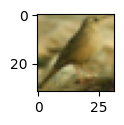

In [7]:
print('Первое изображение:')
plt.subplots(figsize=(1,1))
plt.imshow(X_train[0])
plt.show()

In [8]:
print('Количество классов в train: ', len(np.unique(y_train)))
print('Количество классов в valid: ', len(np.unique(y_valid)))
print('Количество классов в test: ', len(np.unique(y_test)))

Количество классов в train:  10
Количество классов в valid:  10
Количество классов в test:  10


__Ответ:__     
Набор сотстоит из цветных изображений, размер 32*32 пиксилей. Кол-во изображений 50000 в тренировочном наборе и 10000 в тестовом наборе. Классов всего 10:    
0 - airplane(самолет).   
1	- automobile(автомобиль).   
2	- bird(птица).   
3	- cat(кошки).   
4	- deer(олень).   
5	- dog(сабаки).   
6	- frog(лягушка).   
7	- horse(лошадь).   
8	- ship(корабль).   
9	- truck(грузовики).   

__Проверяем диссбаланс в выборках__

In [9]:
name_class1, count_class1 = np.unique(y_train, return_counts=True)
name_class2, count_class2 = np.unique(y_valid, return_counts=True)
name_class3, count_class3 = np.unique(y_test, return_counts=True)

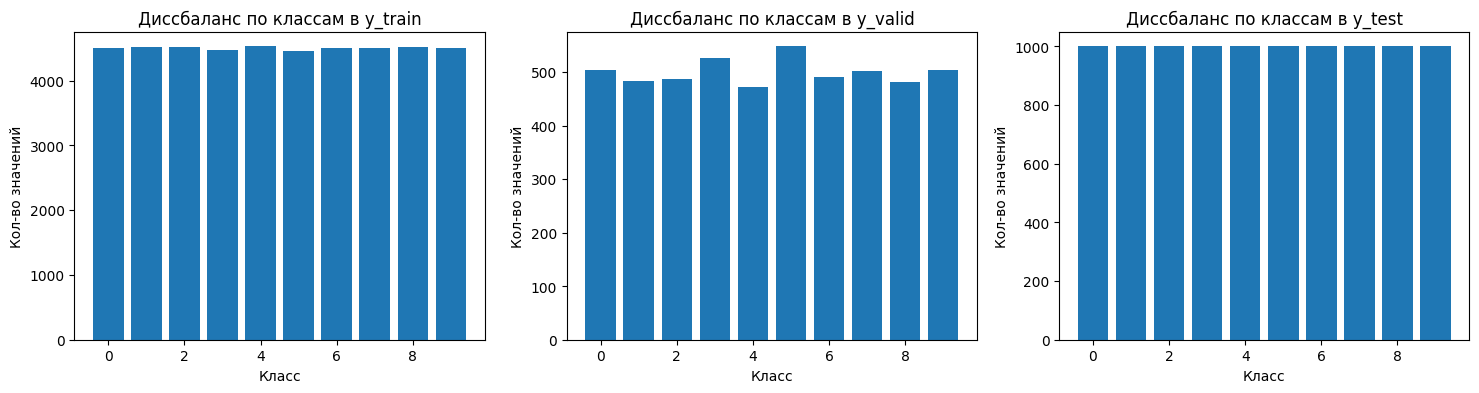

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

axs[0].bar(name_class1, count_class1)
axs[0].set_title('Диссбаланс по классам в y_train')
axs[0].set_xlabel('Класс')
axs[0].set_ylabel('Кол-во значений')

axs[1].bar(name_class2, count_class2)
axs[1].set_title('Диссбаланс по классам в y_valid')
axs[1].set_xlabel('Класс')
axs[1].set_ylabel('Кол-во значений')

axs[2].bar(name_class3, count_class3)
axs[2].set_title('Диссбаланс по классам в y_test')
axs[2].set_xlabel('Класс')
axs[2].set_ylabel('Кол-во значений')

plt.show()

### 4. Проверьте набор данных на наличие пропусков и дубликатов.

In [11]:
print(f'Кол-во пропусков в X_train: {np.isnan(X_train).sum()}, y_train: {np.isnan(y_train).sum()}')
print(f'Кол-во пропусков в X_test: {np.isnan(X_test).sum()}, y_test: {np.isnan(y_test).sum()}')

Кол-во пропусков в X_train: 0, y_train: 0
Кол-во пропусков в X_test: 0, y_test: 0


In [12]:
len(X_train[0].flatten())

3072

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
df = pd.DataFrame(data= [X_train[indx].flatten() for indx in range(X_train.shape[0])],
                  columns= [f"{symb}_pix_{num}" for symb in ['R', 'G', 'B'] for num in range(1024)])

In [ ]:
df.head()

,R_pix_0,R_pix_1,R_pix_2,R_pix_3,R_pix_4,R_pix_5,R_pix_6,R_pix_7,R_pix_8,R_pix_9,...,B_pix_1014,B_pix_1015,B_pix_1016,B_pix_1017,B_pix_1018,B_pix_1019,B_pix_1020,B_pix_1021,B_pix_1022,B_pix_1023
0,59,62,63,43,46,45,50,48,43,68,...,104,216,184,140,151,118,84,123,92,72
1,154,177,187,126,137,136,105,104,95,102,...,136,143,133,139,143,134,142,143,133,144
2,255,255,255,253,253,253,253,253,253,253,...,79,78,85,83,79,85,83,80,86,84
3,28,25,10,37,34,19,38,35,20,42,...,38,54,47,28,63,56,37,72,65,46
4,170,180,198,168,178,196,177,185,203,183,...,78,75,79,82,71,75,78,73,77,80


In [ ]:
print('Кол-во дубликатов: ', df.duplicated().sum())

Кол-во дубликатов:  0


### 5. Отрисуйте десять примеров с различными метками классов.

In [ ]:
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [ ]:
ind_class = []
for num_class in range(10):
  ind_class.append(np.where(y_train == num_class)[0][0])
ind_class

[29, 4, 6, 9, 3, 27, 0, 7, 8, 1]

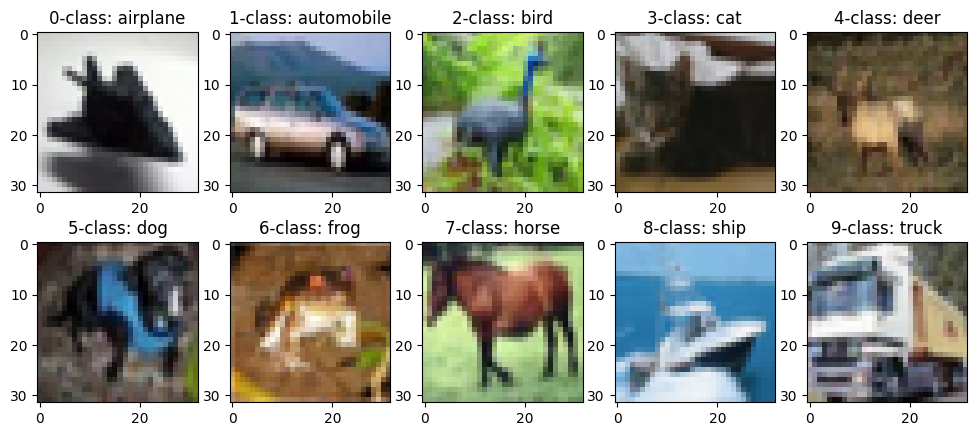

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))

for indx1, indx2 in enumerate(ind_class[:5]):
  axs[0, indx1].imshow(X_train[indx2])
  axs[0, indx1].set_title(f'{y_train[indx2][0]}-class: {class_name[y_train[indx2][0]]}')

for indx1, indx2 in enumerate(ind_class[5:]):
  axs[1, indx1].imshow(X_train[indx2])
  axs[1, indx1].set_title(f'{y_train[indx2][0]}-class: {class_name[y_train[indx2][0]]}')

plt.show()

### 6. Подумайте, как стоит преобразовать входные и выходные данные, чтобы нейронная сеть могла лучше с ними работать. Выполните эти преобразования.

In [7]:
X_train_norm = X_train / 255
X_valid_norm = X_valid / 255
X_test_norm = X_test / 255

y_train_cat = to_categorical(y_train, 10)
y_valid_cat = to_categorical(y_valid, 10)
y_test_cat = to_categorical(y_test, 10)

### 7. Выберите архитектуру нейронной сети в 1–3 вариантах.

In [7]:
input_shape = (32, 32, 3)

#### __Модель 1__

##### Архитектура модели 1

In [12]:
model_1 = keras.Sequential([
    keras.Input(shape=input_shape),
    Flatten(),
    Dense(700, activation='relu'),
    Dense(10, activation='softmax'),
])

model_1.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

##### Обучение модели 1

In [10]:
%%time

history_model_1 = model_1.fit(X_train_norm, y_train_cat,
                              batch_size=32, epochs=10,
                              validation_data=(X_valid_norm, y_valid_cat))

Epoch 1/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5390 - accuracy: 0.4517 - val_loss: 1.5748 - val_accuracy: 0.4286
Epoch 2/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5143 - accuracy: 0.4630 - val_loss: 1.5560 - val_accuracy: 0.4430
Epoch 3/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5014 - accuracy: 0.4656 - val_loss: 1.5195 - val_accuracy: 0.4646
Epoch 4/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.4837 - accuracy: 0.4735 - val_loss: 1.5323 - val_accuracy: 0.4500
Epoch 5/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.4703 - accuracy: 0.4760 - val_loss: 1.5071 - val_accuracy: 0.4536
Epoch 6/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.4555 - accuracy: 0.4828 - val_loss: 1.4880 - val_accuracy: 0.4622
Epoch 7/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.4455 - accuracy: 0.4851 - val_loss: 1.5015 - val_accuracy:

#### __Модель 2__

##### Архитектура модели 2

In [13]:
model_2 = keras.Sequential([keras.Input(shape=input_shape)])
model_2.add(Flatten())
model_2.add(Dense(700, activation='relu'))
model_2.add(Dropout(0.8))
model_2.add(Dense(10, activation='softmax'))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 700)               2151100   
                                                                 
 dropout (Dropout)           (None, 700)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                7010      
                                                                 
Total params: 2,158,110
Trainable params: 2,158,110
Non-trainable params: 0
_________________________________________________________________


In [14]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

##### Обучение модели 2

In [15]:
history_model_2 = model_2.fit(X_train_norm, y_train_cat,
                              batch_size=32, epochs=5,
                              validation_data=(X_valid_norm, y_valid_cat))

Epoch 1/5
1407/1407 [==============================] - 4s 3ms/step - loss: 2.2885 - accuracy: 0.1270 - val_loss: 2.1704 - val_accuracy: 0.1992
Epoch 2/5
1407/1407 [==============================] - 3s 2ms/step - loss: 2.2335 - accuracy: 0.1313 - val_loss: 2.1268 - val_accuracy: 0.1994
Epoch 3/5
1407/1407 [==============================] - 3s 2ms/step - loss: 2.2226 - accuracy: 0.1355 - val_loss: 2.1203 - val_accuracy: 0.2230
Epoch 4/5
1407/1407 [==============================] - 3s 2ms/step - loss: 2.2153 - accuracy: 0.1363 - val_loss: 2.1056 - val_accuracy: 0.2410
Epoch 5/5
1407/1407 [==============================] - 3s 2ms/step - loss: 2.2153 - accuracy: 0.1371 - val_loss: 2.1166 - val_accuracy: 0.1924


#### __Модель 3__

In [16]:
# Настройки
INPUT_SHAPE = (32, 32, 3)
EPOCHS = 40
BATCH_SIZE = 64

weight_decay = 0.0001

##### Архитектура модели 3

https://www.kaggle.com/code/farzadnekouei/cifar-10-image-classification-with-cnn

In [17]:
model_3 = keras.Sequential([keras.Input(shape=INPUT_SHAPE)])
model_3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model_3.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model_3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_3.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model_3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
model_3.add(BatchNormalization())
model_3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_3.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model_3.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model_3.add(BatchNormalization())
model_3.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_3.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model_3.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model_3.add(BatchNormalization())
model_3.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_3.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model_3.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model_3.add(Dense(10, activation='softmax'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [18]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)

model_3.compile(
    optimizer=optimizer, 
    loss="categorical_crossentropy", metrics=["accuracy"],
)

##### Обучение модели 3

In [19]:
history_model_3 = model_3.fit(X_train_norm, y_train_cat,
                              batch_size=BATCH_SIZE, epochs=EPOCHS,
                              validation_data=(X_valid_norm, y_valid_cat))

Epoch 1/40


2024-08-20 13:00:53.236950: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


704/704 [==============================] - 11s 13ms/step - loss: 2.6600 - accuracy: 0.3336 - val_loss: 47.3580 - val_accuracy: 0.1124
Epoch 2/40
704/704 [==============================] - 9s 13ms/step - loss: 2.1478 - accuracy: 0.4405 - val_loss: 2.0163 - val_accuracy: 0.4410
Epoch 3/40
704/704 [==============================] - 9s 13ms/step - loss: 1.6118 - accuracy: 0.5537 - val_loss: 1.5637 - val_accuracy: 0.5620
Epoch 4/40
704/704 [==============================] - 9s 13ms/step - loss: 1.3851 - accuracy: 0.6224 - val_loss: 1.4960 - val_accuracy: 0.6006
Epoch 5/40
704/704 [==============================] - 9s 13ms/step - loss: 1.2757 - accuracy: 0.6765 - val_loss: 1.3926 - val_accuracy: 0.6394
Epoch 6/40
704/704 [==============================] - 9s 13ms/step - loss: 1.2465 - accuracy: 0.7022 - val_loss: 1.6722 - val_accuracy: 0.5856
Epoch 7/40
704/704 [==============================] - 9s 13ms/step - loss: 1.2453 - accuracy: 0.7171 - val_loss: 1.4506 - val_accuracy: 0.6614
Epoch 8/

### 8. Автоматически подберите оптимальные настройки гиперпараметров.

In [21]:
def build_model(hp):
    model = keras.Sequential([keras.Input(shape=INPUT_SHAPE)])
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # Add the second convolutional layer similar to the first
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())

    # Add the first max pooling layer with pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))

    # Add the third and fourth convolutional layers with 64 filters
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())

    # Add the second max pooling layer and increase dropout rate to 0.3
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.3))

    # Add the fifth and sixth convolutional layers with 128 filters
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())

    # Add the third max pooling layer and increase dropout rate to 0.4
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.4))

    # Add the seventh and eighth convolutional layers with 256 filters
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())

    # Add the fourth max pooling layer and increase dropout rate to 0.5
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    
    # Подбор гиперпараметра
    model.add(Dropout(rate=hp.Float('rate', min_value=0, max_value=1, step=0.2)))

    model.add(Flatten())
    
    # Подбор гиперпараметра
    model.add(Dense(units=hp.Int('units', min_value=100, max_value=1001, step=100),
                               activation=hp.Choice('activation', ['relu', 'tanh'])
                               ))
    # Add a fully connected layer with softmax activation function for outputting class probabilities
    model.add(Dense(10, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(learning_rate=0.005)

    model.compile(
        optimizer=optimizer, 
        loss="categorical_crossentropy", metrics=["accuracy"],
    )
    
    return model

In [22]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [23]:
tuner.search(X_train_norm, y_train_cat, epochs=40,
             validation_data=(X_valid_norm, y_valid_cat)
             )

Trial 5 Complete [00h 16m 11s]
val_accuracy: 0.5354999899864197

Best val_accuracy So Far: 0.7739000022411346
Total elapsed time: 01h 22m 03s


In [24]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
rate: 0.4
units: 300
activation: relu
Score: 0.7739000022411346

Trial 1 summary
Hyperparameters:
rate: 0.2
units: 1000
activation: relu
Score: 0.7736000120639801

Trial 3 summary
Hyperparameters:
rate: 0.6000000000000001
units: 1000
activation: relu
Score: 0.7722000181674957

Trial 0 summary
Hyperparameters:
rate: 0.6000000000000001
units: 500
activation: relu
Score: 0.7721000015735626

Trial 4 summary
Hyperparameters:
rate: 0.6000000000000001
units: 100
activation: tanh
Score: 0.5354999899864197


In [25]:
models = tuner.get_best_models()
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [26]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.space)
print(best_hps.values)

[Float(name: 'rate', min_value: '0.0', max_value: '1.0', step: '0.2', sampling: 'linear', default: '0.0'), Int(name: 'units', min_value: 100, max_value: 1001, step: 100, sampling: linear, default: 100), Choice(name: 'activation', values: ['relu', 'tanh'], ordered: False, default: relu)]
{'rate': 0.4, 'units': 300, 'activation': 'relu'}


### 9. Запустите обучение нейронной сети, подключив валидацию на тестовом множестве. Необходимо использовать как минимум один callback. Сохраните историю обучения в history.

In [29]:
# Настройки
INPUT_SHAPE = (32, 32, 3)
EPOCHS = 300
BATCH_SIZE = 64

weight_decay = 0.0001

In [41]:
model = keras.Sequential([keras.Input(shape=INPUT_SHAPE)])

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2))) 

# Подбор гиперпараметра
model.add(Dropout(rate=0.4))

model.add(Flatten())

# Подбор гиперпараметра
# model.add(Dense(units=300, activation='relu'))
# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.005)

model.compile(
    optimizer=optimizer, 
    loss="categorical_crossentropy", metrics=["accuracy"],
)  

In [59]:
my_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0000001, patience=2, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath='mymodel.{epoch:02d}-{val_accuracy:.3f}.h7', 
                                    save_best_only=True, monitor='loss', verbose=1),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [60]:
history_model_1 = model.fit(X_train_norm, y_train_cat,
                              batch_size=BATCH_SIZE, epochs=EPOCHS,
                              callbacks=my_callbacks,
                              validation_data=(X_valid_norm, y_valid_cat))

Epoch 1/300
700/704 [============================>.] - ETA: 0s - loss: 0.9110 - accuracy: 0.8024
Epoch 1: loss improved from inf to 0.91132, saving model to mymodel.01-0.790.h7


2024-08-20 15:38:07.134419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,32]
	 [[{{node inputs}}]]
2024-08-20 15:38:07.159388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,8,8,64]
	 [[{{node inputs}}]]
2024-08-20 15:38:07.184931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,4,128]
	 [[{{node inputs}}]]
2024

INFO:tensorflow:Assets written to: mymodel.01-0.790.h7/assets


INFO:tensorflow:Assets written to: mymodel.01-0.790.h7/assets


704/704 [==============================] - 13s 19ms/step - loss: 0.9113 - accuracy: 0.8023 - val_loss: 0.9722 - val_accuracy: 0.7904
Epoch 2/300
703/704 [============================>.] - ETA: 0s - loss: 0.9122 - accuracy: 0.8017
Epoch 2: loss did not improve from 0.91132
704/704 [==============================] - 9s 13ms/step - loss: 0.9123 - accuracy: 0.8016 - val_loss: 0.9857 - val_accuracy: 0.7762
Epoch 3/300
703/704 [============================>.] - ETA: 0s - loss: 0.9079 - accuracy: 0.8040
Epoch 3: loss improved from 0.91132 to 0.90787, saving model to mymodel.03-0.813.h7


2024-08-20 15:38:29.445872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,32]
	 [[{{node inputs}}]]
2024-08-20 15:38:29.470846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,8,8,64]
	 [[{{node inputs}}]]
2024-08-20 15:38:29.497094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,4,128]
	 [[{{node inputs}}]]
2024

INFO:tensorflow:Assets written to: mymodel.03-0.813.h7/assets


INFO:tensorflow:Assets written to: mymodel.03-0.813.h7/assets


704/704 [==============================] - 13s 18ms/step - loss: 0.9079 - accuracy: 0.8040 - val_loss: 0.8924 - val_accuracy: 0.8134
Epoch 4/300
701/704 [============================>.] - ETA: 0s - loss: 0.9080 - accuracy: 0.8033
Epoch 4: loss did not improve from 0.90787
704/704 [==============================] - 9s 13ms/step - loss: 0.9081 - accuracy: 0.8033 - val_loss: 1.0150 - val_accuracy: 0.7678
Epoch 5/300
702/704 [============================>.] - ETA: 0s - loss: 0.9081 - accuracy: 0.8036
Epoch 5: loss did not improve from 0.90787
704/704 [==============================] - 9s 13ms/step - loss: 0.9081 - accuracy: 0.8036 - val_loss: 0.9075 - val_accuracy: 0.8056
Epoch 5: early stopping


### 10. Выберите наилучшую архитектуру.

In [62]:
model = keras.models.load_model('/home/jupyter/datasphere/project/mymodel.03-0.813.h7')

# model_1.load_weights('/home/jupyter/datasphere/project/mymodel.18-1.48.h5')

In [63]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

### 11. Визуализируйте графики точности и потерь при обучении.

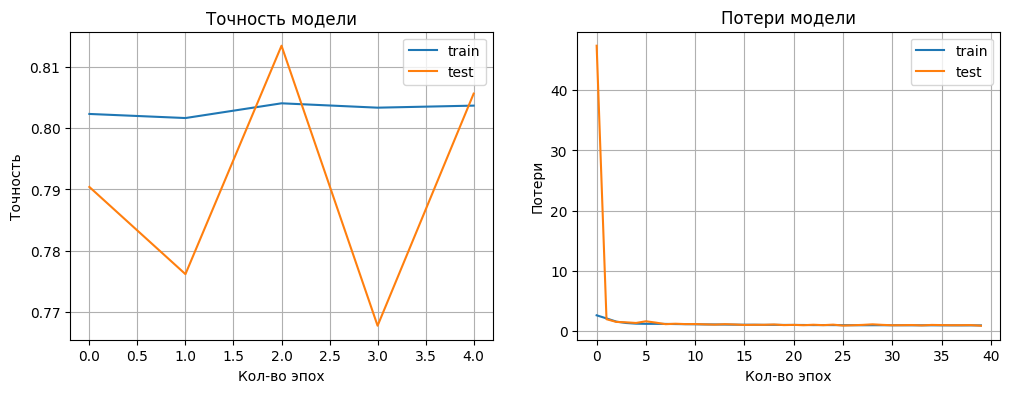

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history_model_1.history['accuracy'], label='train')
axs[0].plot(history_model_1.history['val_accuracy'], label='test')
axs[0].set_title('Точность модели')
axs[0].set_xlabel('Кол-во эпох')
axs[0].set_ylabel('Точность')
axs[0].grid()
axs[0].legend()

axs[1].plot(history_model_3.history['loss'], label='train')
axs[1].plot(history_model_3.history['val_loss'], label='test')
axs[1].set_title('Потери модели')
axs[1].set_xlabel('Кол-во эпох')
axs[1].set_ylabel('Потери')
axs[1].grid()
axs[1].legend()


plt.show()

### 12. Сделайте выводы:    
- Какой тип нейросети показал себя лучше?
- Какие вы пробовали настройки и архитектуры?
- Сложнее ли этот набор данных, чем fashion_mnist? Почему вы так решили?

Сверточная нейросеть показала себя лучше.     
Показано 3 сети, пробывал еще несколько сетей, ничего лучше не получилось.    
Набор данных сложнее, потому что три канала цвета

### 13. По желанию.    
Возьмите стороннюю фотографию, содержащую объект из меток CIFAR10, преобразуйте должным образом и подайте на вход обученной нейросети. Расшифруйте полученный результат, сделайте вывод.